In [ ]:
# monto il drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importo il df
import pandas as pd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
dfOk = pd.read_csv('/content/drive/MyDrive/dm1Progetto/dataset/datasetCopiaSUPEROK.csv')
df = dfOk.copy()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def engineer_player_features(df):
    """Player count features"""
    df["RangePlayers"] = df["MaxPlayers"] - df["MinPlayers"]
    df["IsSoloPlayable"] = (df["MinPlayers"] == 1).astype(int)
    df["IsPartySize"] = (df["MaxPlayers"] >= 8).astype(int)
    return df

def engineer_playtime_features(df):
    """Playtime consistency"""
    df["PlaytimeRange"] = df["ComMaxPlaytime"] - df["ComMinPlaytime"]
    return df

def engineer_popularity_features(df):
    """Popularity-based features"""
    df["DemandRatio"] = df["NumWant"] / (df["NumOwned"] + 1)
    df["OwnershipRatio"] = df["NumOwned"] / (df["NumOwned"] + df["NumWant"] + 1)
    return df

def engineer_category_features(df):
    """Count number of categories"""
    cat_cols = [
        'Cat:Thematic','Cat:Strategy','Cat:War','Cat:Family',
        'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens'
    ]
    df["NumCategories"] = df[cat_cols].sum(axis=1)
    return df

def engineer_rank_features(df):
    """Ranking features: BestRank, AvgRank, RankSpread"""

    rank_cols = [
        'Rank:strategygames','Rank:abstracts','Rank:familygames',
        'Rank:thematic','Rank:cgs','Rank:wargames',
        'Rank:partygames','Rank:childrensgames'
    ]

    # Step 1 — 21926 = "missing", convert to NaN
    df[rank_cols] = df[rank_cols].replace(21926, np.nan)

    # Step 2 — BestRank: se tutte NaN → usa un valore neutro (es. 25000 o NaN)
    df["BestRank"] = df[rank_cols].fillna(25000).min(axis=1)

    # Step 3 — AvgRank: media dei valori REALI, ignorando NaN
    #df["AvgRank"] = df[rank_cols].mean(axis=1)

    # Step 4 — Spread: differenza tra valori validi
    #df["RankSpread"] = df[rank_cols].max(axis=1) - df[rank_cols].min(axis=1)

    return df


def engineer_rankCluster(df):
    # 1. Selezione feature
    X = df[["NumOwned", "NumWant", "GameWeight", "PlaytimeRange"]]

    # 2. Standardizzazione
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X_scaled)

    # 4. Ordina cluster per popolarità media
    cluster_order = df.groupby("Cluster")["NumOwned"].mean().sort_values(ascending=False).index

    # 5. Mappa cluster → rank
    mapping = {cluster: rank+1 for rank, cluster in enumerate(cluster_order)}
    df["RankArtificial"] = df["Cluster"].map(mapping)

    return df

def engineer_artificial_score(df, weights=None, features=None, ascending=False):
    """
    Artificial Score & RankScore based on a weighted linear combination of features.

    Parametri:
    - df: DataFrame dei giochi
    - weights: dict feature -> peso
               Se None, usa pesi di default
    - features: lista delle feature da usare.
                Se None usa le key di weights
    - ascending: True → rank basso = migliore,
                 False → rank alto = migliore

    Output:
    - df con colonne:
        • Score
        • RankScore
    """

    # 1. Default weights
    if weights is None:
        weights = {
            "NumOwned": 0.4,
            "NumWant": 0.2,
            "NumWeightVotes": 0.2,
            "GameWeight": 0.1,
            "PlaytimeRange": -0.1
        }

    # 2. Default feature list
    if features is None:
        features = list(weights.keys())

    # 3. Compute weighted score
    df["Score"] = sum(df[f] * weights[f] for f in features)

    # 4. Rank computed score
    df["RankScore"] = df["Score"].rank(ascending=ascending)

    return df



def apply_all_feature_engineering(df):
    """Apply all FE steps in correct order"""
    df = engineer_player_features(df)
    df = engineer_playtime_features(df)
    df = engineer_popularity_features(df)
    df = engineer_category_features(df)
    df = engineer_rank_features(df)
    df = engineer_rankCluster(df)
    df = engineer_artificial_score(df)
    return df

In [ ]:
df = apply_all_feature_engineering(df)

In [ ]:
df.columns.to_list()

['BGGId',
 'Name',
 'Description',
 'YearPublished',
 'GameWeight',
 'MinPlayers',
 'MaxPlayers',
 'ComAgeRec',
 'LanguageEase',
 'BestPlayers',
 'GoodPlayers',
 'NumOwned',
 'NumWant',
 'NumWeightVotes',
 'ComMinPlaytime',
 'ComMaxPlaytime',
 'MfgAgeRec',
 'NumAlternates',
 'NumExpansions',
 'NumImplementations',
 'IsReimplementation',
 'Kickstarted',
 'Rank:strategygames',
 'Rank:abstracts',
 'Rank:familygames',
 'Rank:thematic',
 'Rank:cgs',
 'Rank:wargames',
 'Rank:partygames',
 'Rank:childrensgames',
 'Cat:Thematic',
 'Cat:Strategy',
 'Cat:War',
 'Cat:Family',
 'Cat:CGS',
 'Cat:Abstract',
 'Cat:Party',
 'Cat:Childrens',
 'Rating',
 'LanguageEase_log',
 'RangePlayers',
 'IsSoloPlayable',
 'IsPartySize',
 'PlaytimeRange',
 'DemandRatio',
 'OwnershipRatio',
 'NumCategories',
 'BestRank',
 'Cluster',
 'RankArtificial',
 'Score',
 'RankScore']

In [ ]:
# for col in df.columns:
#     print(df[col].describe()) ;

In [ ]:
import pandas as pd
import numpy as np


df['YearPublished_disc'] = pd.cut(
    df['YearPublished'],
    bins=[-np.inf, 1989, 1999, 2009, 2019, np.inf],
    labels=['<1990','1990s','2000s','2010s','2020s']
)

df['GameWeight_disc'] = pd.cut(
    df['GameWeight'],
    bins=[-0.1, 1.5, 2.5, 5],
    labels=['Light','Medium','Heavy']
)

df['MinPlayers_disc'] = pd.cut(
    df['MinPlayers'],
    bins=[-0.1,1,2,4,10],
    labels=['Solo','Few','Medium','Many']
)

df['MaxPlayers_disc'] = pd.cut(
    df['MaxPlayers'],
    bins=[1,4,6,10,21],
    labels=['Small','Medium','Large','VeryLarge']
)

df['ComAgeRec_disc'] = pd.cut(
    df['ComAgeRec'],
    bins=[0,6,12,18,25],
    labels=['Child','Teen','YoungAdult','Adult']
)

df['NumOwned_log'] = np.log1p(df['NumOwned'])
df['NumOwned_disc'] = pd.qcut(df['NumOwned_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['NumWant_log'] = np.log1p(df['NumWant'])
df['NumWant_disc'] = pd.qcut(df['NumWant_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['NumWeightVotes_log'] = np.log1p(df['NumWeightVotes'])
df['NumWeightVotes_disc'] = pd.qcut(df['NumWeightVotes_log'], q=4, labels=['Low','Medium','High','VeryHigh'])

df['ComMinPlaytime_disc'] = pd.qcut(df['ComMinPlaytime'], q=4, labels=['VeryShort','Short','Medium','Long'])

df['ComMaxPlaytime_disc'] = pd.qcut(df['ComMaxPlaytime'], q=4, labels=['VeryShort','Short','Medium','Long'])

rating_map = {'Low':'Low','Medium':'Medium','High':'High'}
df['Rating_disc'] = df['Rating'].map(rating_map)


df['RangePlayers_disc'] = pd.cut(
    df['RangePlayers'],
    bins=[-1, 1, 3, 6, np.inf],
    labels=['VeryLow','Low','Medium','High']
)


df['IsSoloPlayable_disc'] = df['IsSoloPlayable'].map({0:'NoSolo', 1:'Solo'})


df['IsPartySize_disc'] = df['IsPartySize'].map({0:'NotParty', 1:'Party'})


df['PlaytimeRange_disc'] = pd.cut(
    df['PlaytimeRange'],
    bins=[-1, 0, 5, 30, 100, np.inf],
    labels=['None','VeryShort','Short','Medium','Long']
)

df['DemandRatio_disc'] = pd.cut(
    df['DemandRatio'],
    bins=[-0.1, 0, 0.01, 0.05, 0.5, np.inf],
    labels=['Zero','Micro','VeryLow','Low','MediumHigh']
)

df['OwnershipRatio_disc'] = pd.cut(
    df['OwnershipRatio'],
    bins=[-0.01, 0.90, 0.96, 0.98, 1.01],
    labels=['Low','Medium','High','VeryHigh']
)

df['NumCategories_disc'] = pd.cut(
    df['NumCategories'],
    bins=[-1, 0, 1, np.inf],
    labels=['None','One','Multiple']
)

df['BestRank_disc'] = pd.cut(
    df['BestRank'],
    bins=[-1, 500, 10000, 24999, 25000],
    labels=['Top500','Top10k','Good','Worst']
)

df['Cluster_disc'] = df['Cluster'].astype(int).astype(str)

df['RankArtificial_disc'] = df['RankArtificial'].astype(int).astype(str)


df['Score_log'] = np.log1p(df['Score'] - df['Score'].min() + 1)
df['Score_disc'] = pd.qcut(
    df['Score_log'],
    q=[0, .25, .5, .75, .90, .99, 1.0],
    labels=['VeryLow','Low','Medium','High','VeryHigh','Extreme']
)


df['RankScore_disc'] = pd.qcut(
    df['RankScore'],
    q=4,
    labels=['Q1','Q2','Q3','Q4']
)


df = df.drop(columns=['Score_log'])

df = df.drop(columns=['NumOwned_log','NumWant_log','NumWeightVotes_log'])

print(df[['YearPublished_disc','GameWeight_disc','MinPlayers_disc','MaxPlayers_disc',
          'ComAgeRec_disc','NumOwned_disc','NumWant_disc','NumWeightVotes_disc',
          'ComMinPlaytime_disc','ComMaxPlaytime_disc','Rating_disc', 'RangePlayers_disc','IsSoloPlayable_disc','IsPartySize_disc',
           'PlaytimeRange_disc','DemandRatio_disc','OwnershipRatio_disc',
           'NumCategories_disc','BestRank_disc','Cluster_disc',
           'RankArtificial_disc','Score_disc','RankScore_disc']].head())


  YearPublished_disc GameWeight_disc MinPlayers_disc MaxPlayers_disc  \
0              2010s          Medium             Few           Small   
1              2020s           Light             Few          Medium   
2              2020s           Heavy            Solo          Medium   
3              2000s           Light             Few           Small   
4              2010s           Light             Few           Small   

  ComAgeRec_disc NumOwned_disc NumWant_disc NumWeightVotes_disc  \
0           Teen          High       Medium              Medium   
1           Teen           Low         High              Medium   
2           Teen          High     VeryHigh              Medium   
3           Teen        Medium          Low                High   
4           Teen        Medium       Medium                 Low   

  ComMinPlaytime_disc ComMaxPlaytime_disc  ... IsPartySize_disc  \
0               Short           VeryShort  ...         NotParty   
1           VeryShort         

In [ ]:
features_pm = [
 'YearPublished_disc','GameWeight_disc',
          'ComAgeRec_disc','NumWeightVotes_disc',
          'Rating_disc', 'RangePlayers_disc','IsSoloPlayable_disc','IsPartySize_disc',
           'PlaytimeRange_disc','DemandRatio_disc','OwnershipRatio_disc',
           'NumCategories_disc'
]

df = df[features_pm]

print(df.head())

  YearPublished_disc GameWeight_disc ComAgeRec_disc NumWeightVotes_disc  \
0              2010s          Medium           Teen              Medium   
1              2020s           Light           Teen              Medium   
2              2020s           Heavy           Teen              Medium   
3              2000s           Light           Teen                High   
4              2010s           Light           Teen                 Low   

  Rating_disc RangePlayers_disc IsSoloPlayable_disc IsPartySize_disc  \
0         Low               Low              NoSolo         NotParty   
1      Medium               Low              NoSolo         NotParty   
2        High            Medium                Solo         NotParty   
3         Low           VeryLow              NoSolo         NotParty   
4      Medium               Low              NoSolo         NotParty   

  PlaytimeRange_disc DemandRatio_disc OwnershipRatio_disc NumCategories_disc  
0               None          VeryLow

In [ ]:
X = df.apply(
    lambda row: [f"{col}={row[col]}" for col in df.columns],
    axis=1
).tolist()


In [ ]:
X[0]

['YearPublished_disc=2010s',
 'GameWeight_disc=Medium',
 'ComAgeRec_disc=Teen',
 'NumWeightVotes_disc=Medium',
 'Rating_disc=Low',
 'RangePlayers_disc=Low',
 'IsSoloPlayable_disc=NoSolo',
 'IsPartySize_disc=NotParty',
 'PlaytimeRange_disc=None',
 'DemandRatio_disc=VeryLow',
 'OwnershipRatio_disc=VeryHigh',
 'NumCategories_disc=None']

## Apriori

| Parametro            | Valore tipico | Note                                                                |
| -------------------- | ------------- | ------------------------------------------------------------------- |
| Support              | 0.5–5%        | Dataset grandi: support >1% robusto; target raro: support più basso |
| Confidence           | 50–80%        | Più alta → regola affidabile; attenzione a valori troppo bassi      |
| Lift                 | >1.5          | Indica che l’associazione è interessante; più alto → più forte      |
| Lunghezza antecedent | 2–4           | Troppi item → regole rare e meno interpretabili                     |


In [ ]:
!pip install pyfim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfim: filename=pyfim-6.28-cp312-cp312-linux_x86_64.whl size=647322 sha256=5c5b4c9a29098c8c63728700058594bcbf45e33b7522f2600a811ecebc18f8ab
  Stored in directory: /root/.cache/pip/wheels/4f/f8/fc/9c22754402de057faecaeb2bb88208898bb0c6eff5ffbfd618
Successfully built pyfim


In [ ]:
from fim import apriori

In [ ]:
# frequent itemset >= min_supp


   min_support_%  num_patterns
0              1         61824
1              2         22804
2              3         11825
3              4          7080
4              8          1807


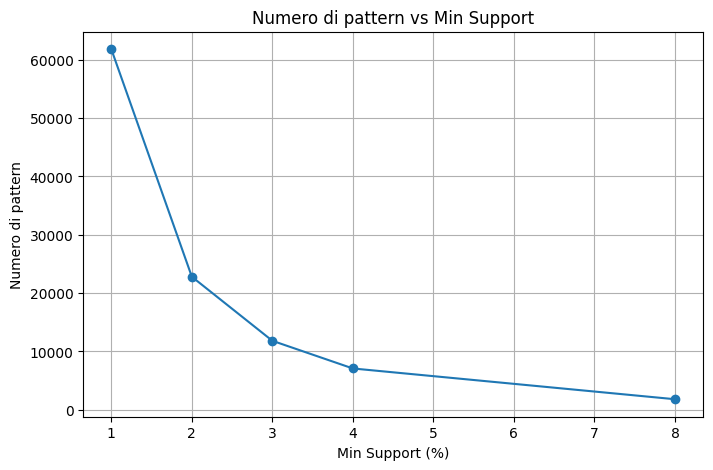


Top 10 pattern per min_support=1%:
Pattern: ('IsSoloPlayable_disc=NoSolo', 'IsPartySize_disc=NotParty'), Support: 73.05359179019383
Pattern: ('ComAgeRec_disc=Teen', 'IsPartySize_disc=NotParty'), Support: 64.1824401368301
Pattern: ('ComAgeRec_disc=Teen', 'IsSoloPlayable_disc=NoSolo'), Support: 60.97605473204105
Pattern: ('ComAgeRec_disc=Teen', 'IsSoloPlayable_disc=NoSolo', 'IsPartySize_disc=NotParty'), Support: 53.55986316989738
Pattern: ('PlaytimeRange_disc=None', 'IsSoloPlayable_disc=NoSolo'), Support: 52.65222348916762
Pattern: ('PlaytimeRange_disc=None', 'IsPartySize_disc=NotParty'), Support: 52.36031927023945
Pattern: ('RangePlayers_disc=Low', 'IsPartySize_disc=NotParty'), Support: 47.265678449258836
Pattern: ('PlaytimeRange_disc=None', 'IsSoloPlayable_disc=NoSolo', 'IsPartySize_disc=NotParty'), Support: 46.043329532497154
Pattern: ('DemandRatio_disc=VeryLow', 'IsPartySize_disc=NotParty'), Support: 44.953249714937286
Pattern: ('PlaytimeRange_disc=None', 'ComAgeRec_disc=Teen'), Sup

In [ ]:
from fim import apriori
import pandas as pd
import matplotlib.pyplot as plt


supports = [1, 2, 3, 4, 8]  # supporti in percentuale
results = []
all_itemsets = {}

for supp in supports:

    itemsets = apriori(
        X,
        target='s',    # estrazione frequent patterns
        supp=supp,
        zmin=2,        # pattern di almeno 2 item
        report='S'     # restituisce supporti
    )
    # Salvo tutti i pattern per analisi qualitative
    all_itemsets[supp] = itemsets
    results.append({
        "min_support_%": supp,
        "num_patterns": len(itemsets)
    })


df_support_analysis = pd.DataFrame(results)
print(df_support_analysis)

# Grafico: numero di pattern vs supporto
plt.figure(figsize=(8,5))
plt.plot(df_support_analysis['min_support_%'], df_support_analysis['num_patterns'], marker='o')
plt.title('Numero di pattern vs Min Support')
plt.xlabel('Min Support (%)')
plt.ylabel('Numero di pattern')
plt.grid(True)
plt.show()


# Esaminiamo i primi 10 pattern più frequenti per ciascun supporto
for supp in supports:
    print(f"\nTop 10 pattern per min_support={supp}%:")
    # ordina per supporto decrescente
    sorted_itemsets = sorted(all_itemsets[supp], key=lambda x: x[1], reverse=True)
    for pattern, support in sorted_itemsets[:10]:
        print(f"Pattern: {pattern}, Support: {support}")


ar extraction

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
conf = 50
rules = apriori(X, target="r", supp=8, zmin=2, conf=conf, report="aScl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False)

consequent  \
0             DemandRatio_disc=Low   
400      ComAgeRec_disc=YoungAdult   
407      ComAgeRec_disc=YoungAdult   
405      ComAgeRec_disc=YoungAdult   
408      ComAgeRec_disc=YoungAdult   
409      ComAgeRec_disc=YoungAdult   
431      ComAgeRec_disc=YoungAdult   
428      ComAgeRec_disc=YoungAdult   
416      ComAgeRec_disc=YoungAdult   
273         DemandRatio_disc=Micro   
415      ComAgeRec_disc=YoungAdult   
158         DemandRatio_disc=Micro   
419          GameWeight_disc=Heavy   
427          GameWeight_disc=Heavy   
424      ComAgeRec_disc=YoungAdult   
420      ComAgeRec_disc=YoungAdult   
274         DemandRatio_disc=Micro   
198         DemandRatio_disc=Micro   
430          GameWeight_disc=Heavy   
161         DemandRatio_disc=Micro   
402      ComAgeRec_disc=YoungAdult   
417      ComAgeRec_disc=YoungAdult   
180         DemandRatio_disc=Micro   
423          GameWeight_disc=Heavy   
1310          DemandRatio_disc=Low   
1312          DemandRatio_disc=Low   
1302              Rating_disc=High   
1305              Rating_disc=High   
439          GameWeight_disc=Heavy   
1941          DemandRatio_disc=Low   
1939          DemandRatio_disc=Low   
435          GameWeight_disc=Heavy   
106          GameWeight_disc=Heavy   
1986          DemandRatio_disc=Low   
1989          DemandRatio_disc=Low   
1977    OwnershipRatio_disc=Medium   
1985    OwnershipRatio_disc=Medium   
1358         GameWeight_disc=Heavy   
1981    OwnershipRatio_disc=Medium   
1988    OwnershipRatio_disc=Medium   
249   OwnershipRatio_disc=VeryHigh   
252   OwnershipRatio_disc=VeryHigh   
202   OwnershipRatio_disc=VeryHigh   
340   OwnershipRatio_disc=VeryHigh   
333   OwnershipRatio_disc=VeryHigh   
343   OwnershipRatio_disc=VeryHigh   
323   OwnershipRatio_disc=VeryHigh   
321   OwnershipRatio_disc=VeryHigh   
338   OwnershipRatio_disc=VeryHigh   
327   OwnershipRatio_disc=VeryHigh   
335   OwnershipRatio_disc=VeryHigh   
196   OwnershipRatio_disc=VeryHigh   
318   OwnershipRatio_disc=VeryHigh   
200   OwnershipRatio_disc=VeryHigh   
300   OwnershipRatio_disc=VeryHigh   
315   OwnershipRatio_disc=VeryHigh   
330   OwnershipRatio_disc=VeryHigh   
342   OwnershipRatio_disc=VeryHigh   
296   OwnershipRatio_disc=VeryHigh   
311   OwnershipRatio_disc=VeryHigh   
105          GameWeight_disc=Heavy   
1982          DemandRatio_disc=Low   
440          GameWeight_disc=Heavy   
85        RangePlayers_disc=Medium   
1978          DemandRatio_disc=Low   
1370              Rating_disc=High   
1367              Rating_disc=High   
1360         GameWeight_disc=Heavy   
1352         GameWeight_disc=Heavy   
107          GameWeight_disc=Heavy   
2039    OwnershipRatio_disc=Medium   
1350              Rating_disc=High   
1957    OwnershipRatio_disc=Medium   
1348              Rating_disc=High   
2042    OwnershipRatio_disc=Medium   
2044    OwnershipRatio_disc=Medium   
1960    OwnershipRatio_disc=Medium   
1355         GameWeight_disc=Heavy   
1999    OwnershipRatio_disc=Medium   
437          GameWeight_disc=Heavy   
2087    OwnershipRatio_disc=Medium   
2091    OwnershipRatio_disc=Medium   
2001    OwnershipRatio_disc=Medium   
1964    OwnershipRatio_disc=Medium   
2043          DemandRatio_disc=Low   
2030    OwnershipRatio_disc=Medium   
2032    OwnershipRatio_disc=Medium   
1966    OwnershipRatio_disc=Medium   
1938    OwnershipRatio_disc=Medium   
2022    OwnershipRatio_disc=Medium   
2063    OwnershipRatio_disc=Medium   
2026    OwnershipRatio_disc=Medium   
2102    OwnershipRatio_disc=Medium   
2014    OwnershipRatio_disc=Medium   
2018    OwnershipRatio_disc=Medium   
1997    OwnershipRatio_disc=Medium   
2109          DemandRatio_disc=Low   
2031          DemandRatio_disc=Low   
2105    OwnershipRatio_disc=Medium   
2033          DemandRatio_disc=Low   
2108    OwnershipRatio_disc=Medium   
1940    OwnershipRatio_disc=Medium   
2095    OwnershipRatio_disc=Medium   
2045          DemandRatio_disc=Low   
2098    OwnershipRatio_disc=Medium

In [ ]:
print(f"Numero di regole generate: {len(rules_df)}")


Numero di regole generate: 58943


(array([5597., 5924., 5179., 4386., 3840., 2950., 2324., 1561., 1725.,
       1829., 1661., 1617., 2035., 1897., 1573., 2828., 2266., 1551.,
        478., 7722.]), array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
       0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
       0.95 , 0.975, 1.   ]), <BarContainer object of 20 artists>)


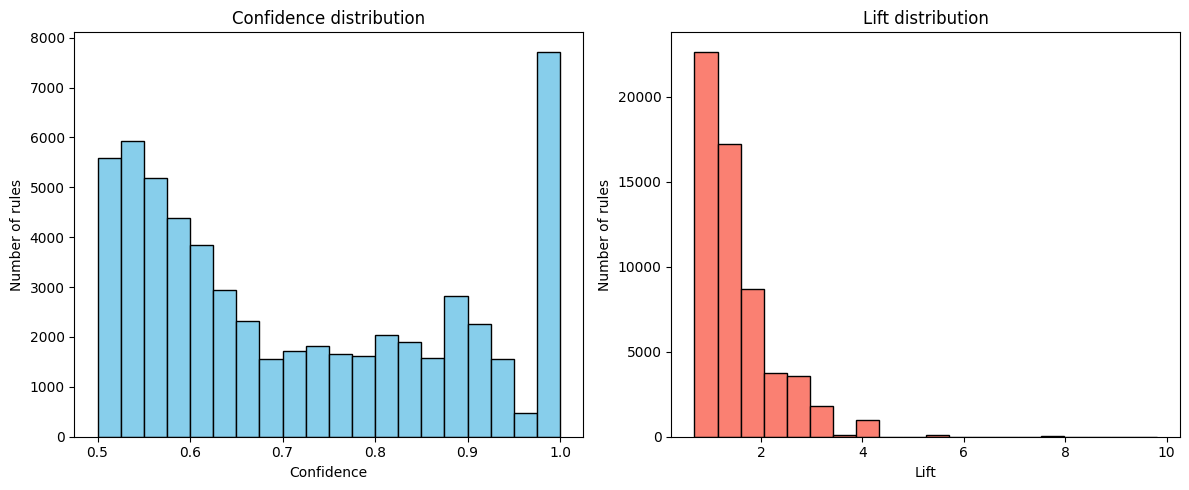

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
out = plt.hist(rules_df['confidence'], bins=20, color='skyblue', edgecolor='black')
print(out)
plt.title('Confidence distribution')
plt.xlabel('Confidence')
plt.ylabel('Number of rules')

plt.subplot(1,2,2)
plt.hist(rules_df['lift'], bins=20, color='salmon', edgecolor='black')
plt.title('Lift distribution')
plt.xlabel('Lift')
plt.ylabel('Number of rules')

plt.tight_layout()
plt.show()


In [ ]:
top_rules = (
    rules_df
    .query("`%_support` >= 1")   # esempio: almeno 1% di supporto
    .sort_values(by='lift', ascending=False)
    .head(10)
)

for _, row in top_rules.iterrows():
    print(
        f"Regola: {row['antecedent']} → {row['consequent']}, "
        f"Support: {row['%_support']:.2f}%, "
        f"Confidence: {row['confidence']:.2f}%, "
        f"Lift: {row['lift']:.2f}"
    )

Regola: ('OwnershipRatio_disc=Low',) → DemandRatio_disc=Low, Support: 7.83%, Confidence: 0.95%, Lift: 3.88
Regola: ('Rating_disc=High', 'GameWeight_disc=Heavy', 'NumCategories_disc=One') → ComAgeRec_disc=YoungAdult, Support: 4.99%, Confidence: 0.60%, Lift: 3.59
Regola: ('RangePlayers_disc=VeryLow', 'GameWeight_disc=Heavy', 'NumCategories_disc=One') → ComAgeRec_disc=YoungAdult, Support: 4.85%, Confidence: 0.59%, Lift: 3.50
Regola: ('RangePlayers_disc=VeryLow', 'GameWeight_disc=Heavy', 'NumCategories_disc=One', 'IsPartySize_disc=NotParty') → ComAgeRec_disc=YoungAdult, Support: 4.85%, Confidence: 0.59%, Lift: 3.50
Regola: ('RangePlayers_disc=VeryLow', 'GameWeight_disc=Heavy', 'IsPartySize_disc=NotParty') → ComAgeRec_disc=YoungAdult, Support: 5.26%, Confidence: 0.54%, Lift: 3.21
Regola: ('RangePlayers_disc=VeryLow', 'GameWeight_disc=Heavy') → ComAgeRec_disc=YoungAdult, Support: 5.26%, Confidence: 0.54%, Lift: 3.21
Regola: ('GameWeight_disc=Heavy', 'NumCategories_disc=One') → ComAgeRec_disc

In [ ]:
top_rules = rules_df.head(10)
for idx, row in top_rules.iterrows():
    print(f"Regola: {row['antecedent']} → {row['consequent']}, "
          f"Support: {row['%_support']:.2f}%, Confidence: {row['confidence']:.2f}%, Lift: {row['lift']:.2f}")


Regola: ('OwnershipRatio_disc=Low',) → DemandRatio_disc=Low, Support: 7.83%, Confidence: 0.95%, Lift: 3.88
Regola: ('OwnershipRatio_disc=Low',) → BestRank_disc=Worst, Support: 4.29%, Confidence: 0.52%, Lift: 1.02
Regola: ('OwnershipRatio_disc=Low',) → NumCategories_disc=None, Support: 4.29%, Confidence: 0.52%, Lift: 1.02
Regola: ('OwnershipRatio_disc=Low',) → PlaytimeRange_disc=None, Support: 4.38%, Confidence: 0.53%, Lift: 0.89
Regola: ('OwnershipRatio_disc=Low',) → ComAgeRec_disc=Teen, Support: 5.69%, Confidence: 0.69%, Lift: 0.95
Regola: ('OwnershipRatio_disc=Low',) → IsSoloPlayable_disc=NoSolo, Support: 6.04%, Confidence: 0.73%, Lift: 0.88
Regola: ('OwnershipRatio_disc=Low',) → IsPartySize_disc=NotParty, Support: 7.67%, Confidence: 0.93%, Lift: 1.05
Regola: ('DemandRatio_disc=Zero', 'OwnershipRatio_disc=VeryHigh') → RankScore_disc=Q4, Support: 5.15%, Confidence: 0.62%, Lift: 2.48
Regola: ('DemandRatio_disc=Zero', 'IsSoloPlayable_disc=NoSolo') → RankScore_disc=Q4, Support: 5.23%, Co

Support = Rappresenta la frequenza con cui la regola appare nell’intero dataset.
Confidence = È la probabilità che il conseguente sia vero dato l’antecedente
Lift = Misura quanto la presenza dell’antecedente aumenta la probabilità del conseguente rispetto al caso casuale


Osservazioni sulle tue regole:

Le regole con consequente Rating_disc=High hanno lift tra 2.96 e 3.24: quindi sono regole forti.

Support è basso (~2-3%), quindi queste regole riguardano pochi giochi, ma sono significative per quei casi.

Confidence tra 0.68 e 0.74: discreta, conferma che l’antecedente è un buon indicatore del Rating alto.

In [ ]:
rules_df.head(10)

consequent  \
0        DemandRatio_disc=Low   
1         BestRank_disc=Worst   
2     NumCategories_disc=None   
3     PlaytimeRange_disc=None   
4         ComAgeRec_disc=Teen   
5  IsSoloPlayable_disc=NoSolo   
6   IsPartySize_disc=NotParty   
7           RankScore_disc=Q4   
8           RankScore_disc=Q4   
9           RankScore_disc=Q4   

                                          antecedent  abs_support  %_support  \
0                         (OwnershipRatio_disc=Low,)         1717   7.831243   
1                         (OwnershipRatio_disc=Low,)          941   4.291904   
2                         (OwnershipRatio_disc=Low,)          941   4.291904   
3                         (OwnershipRatio_disc=Low,)          961   4.383124   
4                         (OwnershipRatio_disc=Low,)         1247   5.687571   
5                         (OwnershipRatio_disc=Low,)         1325   6.043330   
6                         (OwnershipRatio_disc=Low,)         1682   7.671608   
7  (DemandRatio_disc=Zero, OwnershipRatio_disc=Ve...         1129   5.149373   
8  (DemandRatio_disc=Zero, IsSoloPlayable_disc=No...         1146   5.226910   
9                           (DemandRatio_disc=Zero,)         1245   5.678449   

   confidence      lift  
0    0.951247  3.879479  
1    0.521330  1.022009  
2    0.521330  1.022009  
3    0.532410  0.891280  
4    0.690859  0.950972  
5    0.734072  0.883975  
6    0.931856  1.050974  
7    0.619649  2.478708  
8    0.641657  2.566746  
9    0.642415  2.569777

##Classificazione con regoel

In [ ]:
rating_rules = rules_df[
    rules_df["consequent"].str.contains("Rating_disc")
].copy()

print("Numero regole per Rating:", len(rating_rules))
rating_rules.sort_values(by=["lift", "confidence"], ascending=False).tail(10)


Numero regole per Rating: 4122


consequent                                         antecedent  \
8171   Rating_disc=Medium  (NumWeightVotes_disc=High, GameWeight_disc=Med...   
8816   Rating_disc=Medium  (RankScore_disc=Q2, Score_disc=Medium, ComAgeR...   
9540   Rating_disc=Medium  (RankScore_disc=Q2, ComAgeRec_disc=Teen, IsSol...   
16633  Rating_disc=Medium  (Score_disc=Medium, ComAgeRec_disc=Teen, IsSol...   
5901   Rating_disc=Medium  (RangePlayers_disc=VeryLow, PlaytimeRange_disc...   
42690  Rating_disc=Medium  (GameWeight_disc=Light, RangePlayers_disc=Low,...   
44027  Rating_disc=Medium  (Cluster_disc=1, RankArtificial_disc=4, GameWe...   
47801  Rating_disc=Medium  (Cluster_disc=1, GameWeight_disc=Medium, Playt...   
51019  Rating_disc=Medium  (RankArtificial_disc=4, GameWeight_disc=Medium...   
54926  Rating_disc=Medium  (GameWeight_disc=Medium, PlaytimeRange_disc=None)   

       abs_support  %_support  confidence      lift  
8171           919   4.191562    0.500545  1.137955  
8816          1393   6.353478    0.500359  1.137534  
9540          1393   6.353478    0.500359  1.137534  
16633         1393   6.353478    0.500359  1.137534  
5901           956   4.360319    0.500262  1.137312  
42690          960   4.378563    0.500261  1.137309  
44027         2436  11.110604    0.500205  1.137184  
47801         2436  11.110604    0.500205  1.137184  
51019         2436  11.110604    0.500205  1.137184  
54926         2743  12.510832    0.500000  1.136717

In [ ]:
def predict_rating_from_rules(row, rating_rules):
    """
    row = riga del DataFrame X (una transazione)
    rating_rules = regole con Rating come consequente
    """
    items = set(row)

    candidates = []

    for _, r in rating_rules.iterrows():
        antecedent = set(r["antecedent"])

        # Corrected: Get the consequent string directly
        consequent_item_str = r["consequent"]

        # Ensure that the consequent item string contains '=' before splitting
        if '=' in consequent_item_str:
            rating = consequent_item_str.split("=")[1]
        else:
            # If a consequent doesn't have the expected 'key=value' format, skip this rule
            continue

        # Se l'antecedente è contenuto nel record
        if antecedent.issubset(items):
            conf = r["confidence"]
            lift = r["lift"]
            candidates.append((rating, conf, lift))

    if len(candidates) == 0:
        return "Unknown"

    # scegli la regola con confidence massima (e lift come tie-breaker)
    best = sorted(candidates, key=lambda x: (x[1], x[2]), reverse=True)[0]
    return best[0]

In [ ]:
predicted_ratings = [predict_rating_from_rules(row, rating_rules) for row in X]
df["Predicted_Rating"] = predicted_ratings


In [ ]:
df["True_Rating"] = df["Rating_disc"]


In [ ]:
df[["True_Rating", "Predicted_Rating"]].head()


True_Rating Predicted_Rating
0         Low              Low
1      Medium              Low
2        High             High
3         Low              Low
4      Medium           Medium

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(df["True_Rating"], df["Predicted_Rating"])
print("Accuracy:", acc)



Accuracy: 0.5638312428734321


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ["Low", "Medium", "High"]

cm = confusion_matrix(df["True_Rating"], df["Predicted_Rating"], labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print(cm_df)


         Low  Medium  High
Low     6102    1013   130
Medium  4479    4269   896
High     839    2206  1991


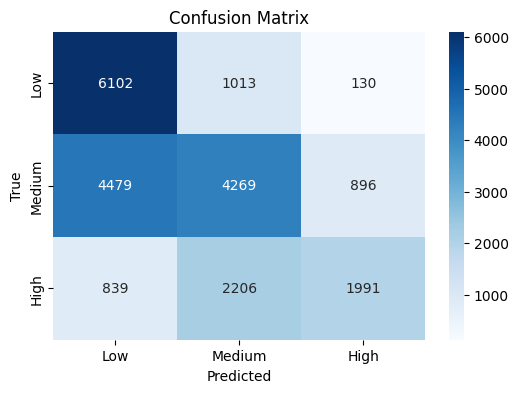

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ["Low", "Medium", "High"]

# Crea la confusion matrix
cm = confusion_matrix(df["True_Rating"], df["Predicted_Rating"], labels=labels)


cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot con seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def generate_rules_with_conf_range(X, conf_values, supp=3, zmin=2):
    """
    X: lista transazioni one-hot
    conf_values: lista di valori di confidence da provare
    supp, zmin: parametri di supporto minimo e dimensione minima regole
    """
    results = {}

    for conf in conf_values:
        rules = apriori(
            X,
            target="r",
            supp=supp,
            zmin=zmin,
            conf=conf,
            report="aScl"
        )

        rules_df = pd.DataFrame(
            rules,
            columns=["consequent", "antecedent", "abs_support", "%_support", "confidence", "lift"]
        )

        # ordina per lift discendente
        rules_df = rules_df.sort_values(by=["lift", "confidence"], ascending=False)

        results[conf] = rules_df

        print(f"\nCONF = {conf}% → Regole generate: {len(rules_df)}")

    return results


In [ ]:
conf_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
all_rules = generate_rules_with_conf_range(X, conf_values)


CONF = 10% → Regole generate: 2533517

CONF = 20% → Regole generate: 1920210

CONF = 30% → Regole generate: 1340492

CONF = 40% → Regole generate: 945305

CONF = 50% → Regole generate: 689691

CONF = 60% → Regole generate: 486882

CONF = 70% → Regole generate: 355472

CONF = 80% → Regole generate: 264561

CONF = 90% → Regole generate: 175585


In [ ]:
all_rules[30].head()


consequent  \
56163  RankArtificial_disc=1   
56164         Cluster_disc=2   
56169  RankArtificial_disc=1   
56170         Cluster_disc=2   
56198  RankArtificial_disc=1   

                                              antecedent  abs_support  \
56163  (Cluster_disc=2, PlaytimeRange_disc=Medium, Co...          798   
56164  (RankArtificial_disc=1, PlaytimeRange_disc=Med...          798   
56169  (Cluster_disc=2, PlaytimeRange_disc=Medium, Co...          833   
56170  (RankArtificial_disc=1, PlaytimeRange_disc=Med...          833   
56198  (Cluster_disc=2, PlaytimeRange_disc=Medium, Co...          671   

       %_support  confidence      lift  
56163   3.639681         1.0  9.805456  
56164   3.639681         1.0  9.805456  
56169   3.799316         1.0  9.805456  
56170   3.799316         1.0  9.805456  
56198   3.060433         1.0  9.805456

In [ ]:
summary = []

# Iterate through the items of the all_rules dictionary
# Each item is (conf_value, rules_dataframe)
for conf, df_rules in all_rules.items():
    summary.append({
        "min_confidence": conf,
        "num_rules": len(df_rules),
        "avg_lift": df_rules["lift"].mean() if not df_rules.empty else 0
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("min_confidence")
summary_df

min_confidence  num_rules  avg_lift
0              10    2533517  1.317940
1              20    1920210  1.440272
2              30    1340492  1.565007
3              40     945305  1.643170
4              50     689691  1.735505
5              60     486882  1.847820
6              70     355472  1.952041
7              80     264561  2.088140
8              90     175585  2.387395

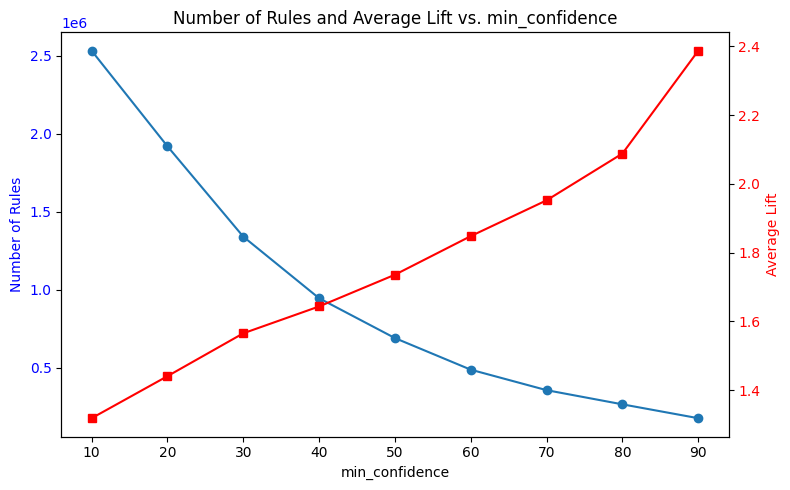

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# Numero di regole (asse sinistro)
ax1.plot(summary_df["min_confidence"], summary_df["num_rules"], marker="o")
ax1.set_xlabel("min_confidence")
ax1.set_ylabel("Number of Rules", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Average lift (asse destro)
ax2 = ax1.twinx()
ax2.plot(summary_df["min_confidence"], summary_df["avg_lift"], marker="s", color="red")
ax2.set_ylabel("Average Lift", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Number of Rules and Average Lift vs. min_confidence")
plt.tight_layout()
plt.show()
